In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(tf.__version__)

2.9.1


In [3]:
label_data = pd.read_csv('C:/Users/SME/Desktop/Python/labeled_data.csv')
label_data

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Reason,Injection_Time,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,5f8928bb9c0189cc666ef19b,2020-10-16 04:57:47,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.59,...,24.799999,27.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5f8928de9c0189cc666ef20b,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.60,...,24.799999,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5f8928df9c0189cc666ef213,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,23,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,24.799999,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5f8928f39c0189cc666ef25e,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,23,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.59,...,25.000000,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5f8928f59c0189cc666ef265,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.59,...,25.000000,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,5fa112859c0189cc66dabe34,2020-11-03 08:17:36,2020-11-03 오전 12:00:00,6,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,21.000000,22.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7992,5fa112869c0189cc66dabe42,2020-11-03 08:18:37,2020-11-03 오전 12:00:00,7,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.60,...,21.000000,22.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7993,5fa112879c0189cc66dabe50,2020-11-03 08:18:37,2020-11-03 오전 12:00:00,6,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,21.000000,22.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7994,5fa112bb9c0189cc66dac22a,2020-11-03 08:19:35,2020-11-03 오전 12:00:00,6,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,21.000000,22.299999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def make_input(data, machine_name ,product_name):
    machine_ = data['EQUIP_NAME'] == machine_name # 3개 존재
    product_ = data['PART_NAME'] == product_name # 6개 존재
    data = data[machine_ & product_]
    
    # 불필요하다고 판단된 columns
    data.drop(['_id','TimeStamp','PART_FACT_PLAN_DATE', 'Reason',
               #'ERR_FACT_QTY', -> 명목형
               'PART_FACT_SERIAL','PART_NAME','EQUIP_CD', 'EQUIP_NAME',
               # mean=0인거 제거
               'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_5', 
               'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8', 
               'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11', 
               'Mold_Temperature_12', 'Barrel_Temperature_7', 'Switch_Over_Position'], 
              axis=1, inplace=True)    
    return data

In [5]:
machine_name = "650톤-우진2호기"
product_name = ["CN7 W/S SIDE MLD'G LH", "CN7 W/S SIDE MLD'G RH", "RG3 MOLD'G W/SHLD, LH", "RG3 MOLD'G W/SHLD, RH"]

# "650톤-우진2호기'의 "CN7 W/S SIDE MLD'G LH" 데이터만 변수를 제거하여 가져옴
cn7lh = make_input(label_data, machine_name, product_name[0])
# "650톤-우진2호기'의 "CN7 W/S  MLD'G RH" 데이터만 변수를 제거하여 가져옴
cn7rh = make_input(label_data, machine_name, product_name[1])
# "650톤-우진2호기'의 “RG3 MOLD’G W/SHLD, LH” 데이터만 변수를 제거하여 가져옴
rg3lh = make_input(label_data, machine_name, product_name[2])
# "650톤-우진2호기'의 “RG3 MOLD’G W/SHLD, RH” 데이터만 변수를 제거하여 가져옴
rg3rh = make_input(label_data, machine_name, product_name[3])

# 동일한 제품의 LH와 RH는 합쳐줌
cn7 = pd.concat([cn7lh, cn7rh], ignore_index=True)
rg3 = pd.concat([rg3lh, rg3rh], ignore_index=True)
rg3

C:\Users\SME\AppData\Local\Temp\ipykernel_18072\4271758534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['_id','TimeStamp','PART_FACT_PLAN_DATE', 'Reason',
C:\Users\SME\AppData\Local\Temp\ipykernel_18072\4271758534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['_id','TimeStamp','PART_FACT_PLAN_DATE', 'Reason',
C:\Users\SME\AppData\Local\Temp\ipykernel_18072\4271758534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,Y,1.06,0.93,13.01,61.779999,6.81,654.289978,53.560001,4.63,128.500000,...,60.299999,286.000000,285.000000,285.000000,275.399994,265.100006,234.899994,65.800003,21.600000,22.500000
1,Y,1.06,0.93,12.99,61.779999,6.81,654.280029,53.580002,4.63,128.500000,...,60.500000,286.200012,285.799988,285.000000,275.600006,265.600006,234.800003,65.800003,21.500000,22.500000
2,Y,1.06,0.93,12.95,61.759998,6.81,654.270020,53.560001,4.63,128.399994,...,60.200001,286.500000,285.100006,285.000000,276.000000,265.100006,234.699997,65.900002,21.500000,22.500000
3,Y,1.06,0.93,13.02,61.779999,6.81,654.270020,53.560001,4.63,128.399994,...,60.400002,285.299988,285.500000,284.500000,276.000000,264.799988,234.800003,65.900002,21.600000,22.500000
4,Y,1.06,0.93,12.97,61.779999,6.81,654.280029,53.560001,4.63,128.399994,...,60.299999,286.299988,285.899994,285.600006,275.399994,265.000000,235.199997,65.800003,21.600000,22.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Y,1.07,0.94,13.06,61.779999,6.79,654.250000,53.610001,4.63,127.500000,...,62.200001,285.600006,284.799988,285.399994,276.100006,265.399994,235.199997,64.400002,22.500000,24.200001
1252,Y,1.07,0.94,13.07,61.759998,6.79,654.260010,53.610001,4.63,127.599998,...,61.900002,285.600006,285.100006,285.000000,275.799988,264.899994,235.100006,64.599998,22.400000,24.200001
1253,Y,1.07,0.94,13.09,61.740002,6.79,654.250000,53.619999,4.63,127.500000,...,61.599998,286.200012,284.799988,285.100006,275.500000,265.000000,235.000000,63.000000,22.600000,24.400000
1254,Y,1.07,0.94,13.12,61.779999,6.79,654.250000,53.610001,4.63,127.500000,...,61.500000,285.899994,284.899994,285.700012,274.899994,265.000000,234.899994,64.500000,22.500000,24.299999


In [6]:
cn7['PassOrFail'] = cn7['PassOrFail'].replace('Y', 0).replace('N', 1)

<AxesSubplot:>

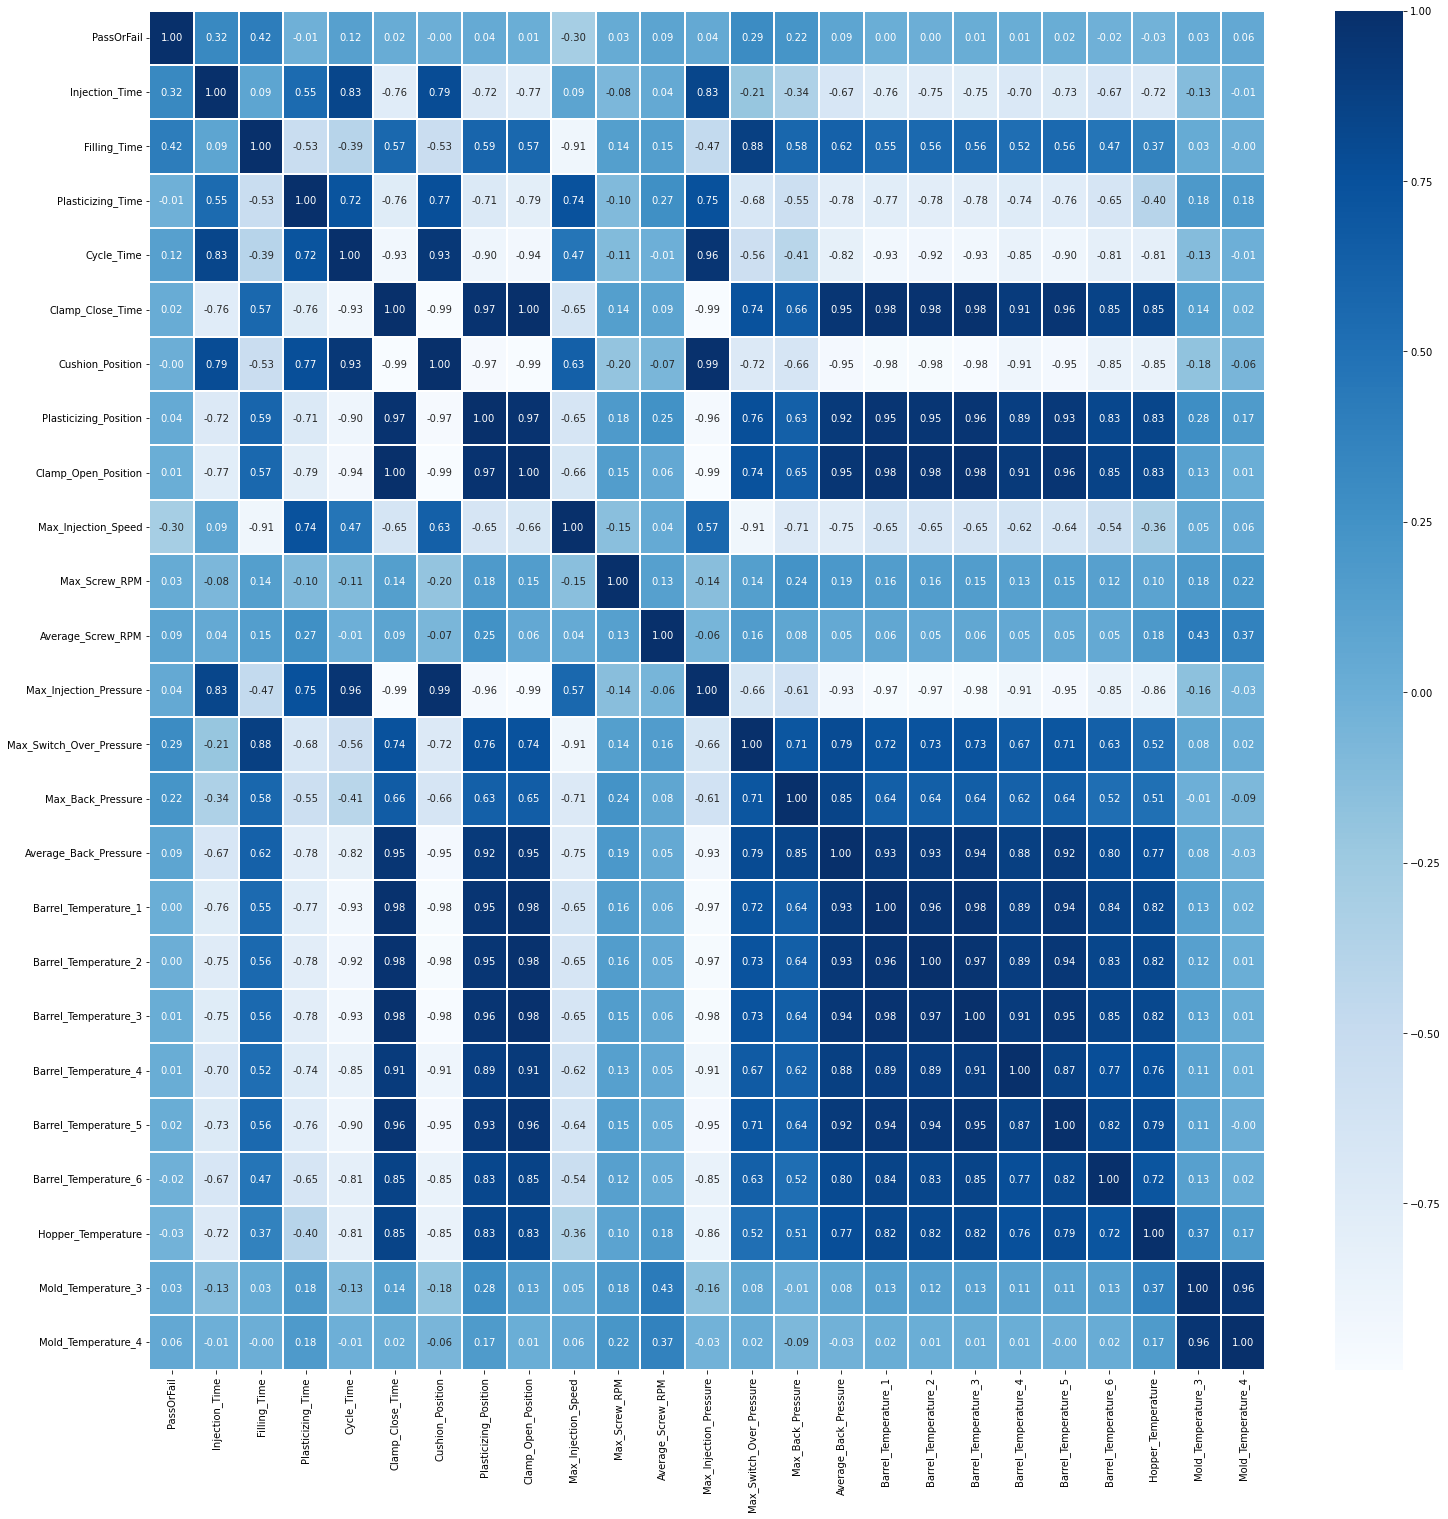

In [7]:
plt.subplots(figsize=(25,25))
sns.heatmap(data = cn7.corr(),linewidths=0.1,annot=True, fmt = '.2f', cmap='Blues')

In [8]:
var_colums = [c for c in cn7.columns if c not in['PassOrFail']]
X = cn7.loc[:,var_colums] # 불량빼고 학습 / 독립변수
Y = cn7.loc[:,'PassOrFail'] # 불량 학습 / 종속변수 
Y.count()

6736

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=42)

In [10]:
#기본적인 randomforest 모형
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

cn7 = RandomForestClassifier(n_estimators=10, max_depth=5) #하이퍼파라미터
# n_estimators : 모델에서 사용할 트리 갯수(학습시 생성할 트리 갯수)
# max_depth : 트리의 최대 깊이
# random_state : 난수 seed 설정
cn7.fit(x_train, y_train)
cn7.score(x_train,y_train) # train 정확도

0.9981440237564959

In [11]:
y_pred = cn7.predict(x_test)
accuracy_score(y_test,y_pred)

0.9977744807121661

In [12]:
y_test.value_counts()

0    1340
1       8
Name: PassOrFail, dtype: int64

In [13]:
from sklearn.metrics import confusion_matrix
test = confusion_matrix(y_test, y_pred)
test

array([[1340,    0],
       [   3,    5]], dtype=int64)

In [14]:
test = pd.DataFrame(test).rename(index={0:'실제값(N)', 1:'실제값(P)'}, columns={0:'예측값(N)', 1:'예측값(P)'})
test # 실제로는 불량인데 정상이라고 판단한 개수 3개 존재

,예측값(N),예측값(P)
실제값(N),1340,0
실제값(P),3,5


# New

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=42)
# stratify=Y 비율이 치우쳐지지 않게
# random_state=42 고정값

In [19]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss # 정확도 함수

cn7 = ExtraTreesClassifier(n_estimators = 10,max_depth = None,min_samples_split = 10, random_state = 0)
cn7.fit(x_train, y_train)
cn7.score(x_train,y_train) # train 정확도

0.9981440237564959

In [20]:
y_pred = cn7.predict(x_test)
accuracy_score(y_test,y_pred)

0.9977744807121661

In [21]:
y_test.value_counts()

0    1340
1       8
Name: PassOrFail, dtype: int64

In [22]:
from sklearn.metrics import confusion_matrix
test = confusion_matrix(y_test, y_pred)
test

array([[1340,    0],
       [   3,    5]], dtype=int64)

In [23]:
test = pd.DataFrame(test).rename(index={0:'실제값(N)', 1:'실제값(P)'}, columns={0:'예측값(N)', 1:'예측값(P)'})
test # 실제로는 불량인데 정상이라고 판단한 개수 3개 존재

,예측값(N),예측값(P)
실제값(N),1340,0
실제값(P),3,5
